In [25]:
import json
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from collections import defaultdict

In [24]:
def process_jsonl(file_path, num_runs, window_size=50):
    with open(file_path, 'r') as file:
        data = [json.loads(line) for line in file]

    runs = defaultdict(list)
    for i, item in enumerate(data):
        runs[int(i/(len(data)/num_runs))].append(item)

    all_average_rewards = []

    for run_id in range(num_runs):
        run_data = runs[run_id]
        run_data.sort(key=lambda x: datetime.strptime(x['task_start_time'], "%Y-%m-%d %H:%M:%S"))

        rewards = [item['reward'] for item in run_data]
        average_rewards = []
        for i in range(0, len(rewards) - window_size + 1):
            average_rewards.append(sum(rewards[i:i+window_size])*1.0 / window_size)
        all_average_rewards.append(average_rewards)

    return all_average_rewards

In [36]:
def plot_average_rewards(num_runs, average_rewards):
    plt.figure(figsize=(12, 6))

    for run_id in range(num_runs):
        plt.plot(range(len(average_rewards[run_id])), average_rewards[run_id])
    plt.title('Average Reward over Time')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.show()

In [34]:
def plot_mean_reward_with_variance(average_rewards):
    plt.figure(figsize=(12, 6))

    rewards_array = np.array(average_rewards)
    mean_rewards = np.mean(rewards_array, axis=0)
    std_rewards = np.std(rewards_array, axis=0)

    x = range(len(mean_rewards))
    plt.plot(x, mean_rewards, label='Mean Reward')

    plt.fill_between(x, mean_rewards - std_rewards, mean_rewards + std_rewards, 
                     alpha=0.2, label='Standard Deviation')

    plt.title('Average Reward over Time')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

In [46]:
def plot_compare_mean_rewards_with_variance(*reward_sets, labels=None, colors=None):
    plt.figure(figsize=(12, 6))

    if labels is None:
        labels = [f'Set {i+1}' for i in range(len(reward_sets))]
    
    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(reward_sets)))

    for idx, (rewards, label, color) in enumerate(zip(reward_sets, labels, colors)):
        rewards_array = np.array(rewards)

        mean_rewards = np.mean(rewards_array, axis=0)
        std_rewards = np.std(rewards_array, axis=0)

        x = range(len(mean_rewards))
        plt.plot(x, mean_rewards, label=f'Mean {label}')

        plt.fill_between(x, mean_rewards - std_rewards, mean_rewards + std_rewards, 
                         alpha=0.2)

    plt.title('Comparison of Mean Rewards over Time with Variance')
    plt.xlabel('Time')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()


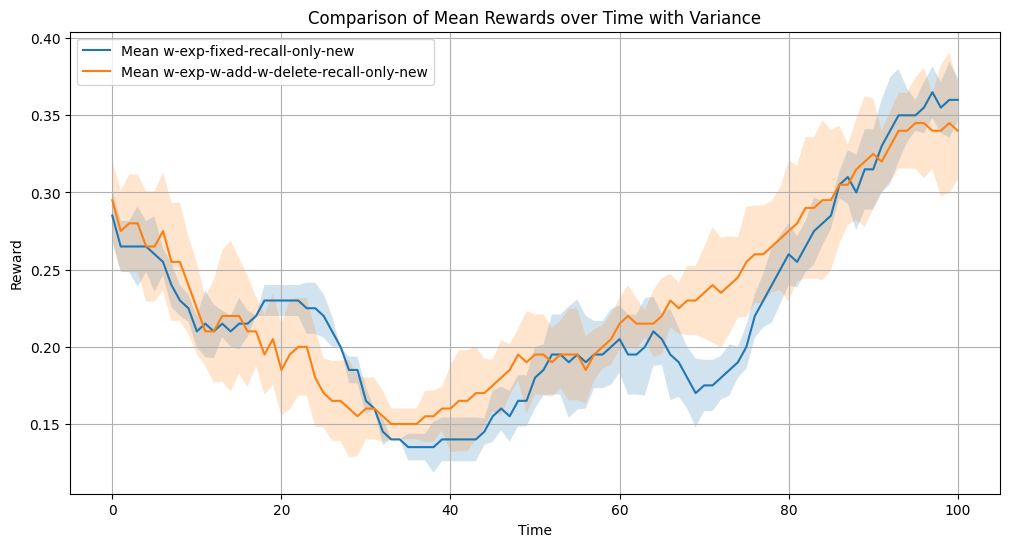

In [51]:
num_runs = 4  
window_size = 50
file_path = 'exp_result/qwen3-8b/no_think/'
file_names = ['bfcl-multi-turn-base-val_w-exp-fixed-recall-only-new.jsonl',
              'bfcl-multi-turn-base-val_w-exp-w-add-w-delete-recall-only-new.jsonl']
labels = [name.split('_')[-1].split('.')[0] for name in file_names]

average_rewards = []
for file_name in file_names:
    average_rewards.append(process_jsonl(file_path+file_name, num_runs, window_size))
# plot_average_rewards(num_runs,average_rewards)
# plot_mean_reward_with_variance(average_rewards)
plot_compare_mean_rewards_with_variance(*average_rewards,labels=labels)

In [ ]:
def plot_difference_from_baseline(reward_sets, labels=None, colors=None):
    plt.figure(figsize=(12, 6))

    if labels is None:
        labels = [f'Set {i+1}' for i in range(len(reward_sets))]
    
    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(reward_sets) - 1))

    baseline_rewards = reward_sets[0]
    min_length = min(len(r) for r in baseline_rewards)
    baseline_rewards = [r[:min_length] for r in baseline_rewards]
    baseline_mean = np.mean(baseline_rewards, axis=0)

    for idx, (rewards, label, color) in enumerate(zip(reward_sets[1:], labels[1:], colors)):
        rewards = [r[:min_length] for r in rewards]

        rewards_array = np.array(rewards)
        mean_rewards = np.mean(rewards_array, axis=0)
        difference = mean_rewards - baseline_mean
        std_difference = np.std(rewards_array, axis=0)

        x = range(min_length)
        plt.plot(x, difference, label=f'{label} vs Baseline')
        plt.fill_between(x, difference - std_difference, difference + std_difference, 
                         alpha=0.2)

    plt.title('Difference in Mean Rewards from Baseline')
    plt.xlabel('Time')
    plt.ylabel('Reward Difference')
    plt.legend()
    plt.grid(True)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

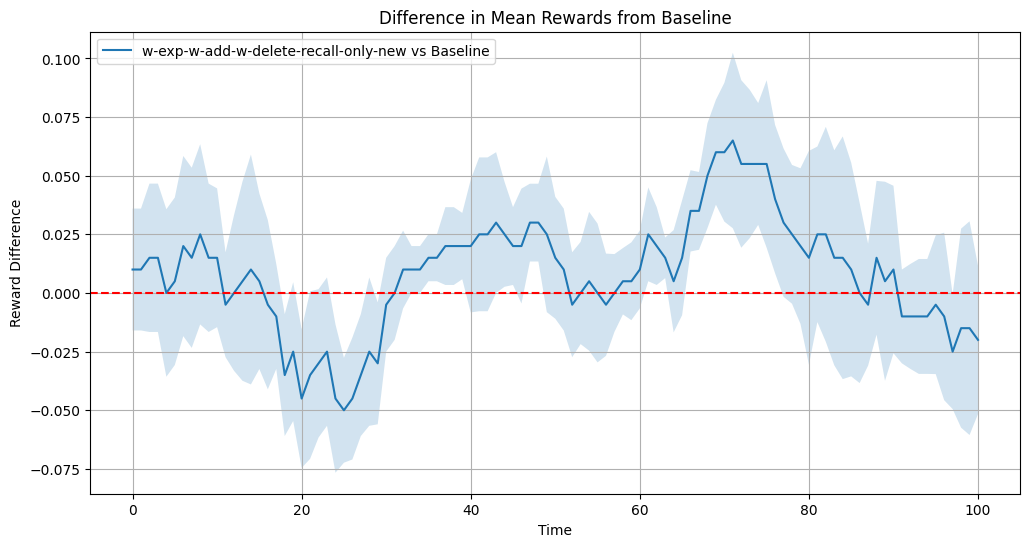

In [52]:
plot_difference_from_baseline(average_rewards, labels=labels)

### **Difference between with exp and without exp**

In [6]:
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd


def process_file(file_path):
    task_results = defaultdict(list)
    with open(file_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            data = json.loads(line)

            if isinstance(data, list):
                for part_data in data:
                    task_id = part_data["task_id"]
                    after_score = part_data["reward"]
                    task_results[task_id].append(after_score)
            else:
                task_id = data["task_id"]
                after_score = data["reward"]
                task_results[task_id].append(after_score)

    if not task_results:
        logger.warning(f"No valid data found in file {file_path}")
        return None

    run_counts = [len(scores) for scores in task_results.values()]
    if len(set(run_counts)) > 1:
        logger.warning(f"Inconsistent number of runs for different tasks in file {file_path}: {set(run_counts)}")
        return None

    return task_results

def run_exp_statistic(model_name, wo_exp_file, w_exp_file):

    wo_exp_results = process_file(wo_exp_file)
    w_exp_results = process_file(w_exp_file)

    if wo_exp_results is None or w_exp_results is None:
        return

    wo_exp_correct = set()
    w_exp_correct = set()

    for task_id, scores in wo_exp_results.items():
        if max(scores) == 1:
            wo_exp_correct.add(task_id)

    for task_id, scores in w_exp_results.items():
        if max(scores) == 1:
            w_exp_correct.add(task_id)

    wo_exp_only_correct = wo_exp_correct - w_exp_correct
    w_exp_only_correct = w_exp_correct - wo_exp_correct

    print("Tasks correct in wo-exp but incorrect in w-exp:")
    print(wo_exp_only_correct)

    print("\nTasks correct in w-exp but incorrect in wo-exp:")
    print(w_exp_only_correct)

if __name__ == "__main__":
    model_name = "qwen-max-2025-01-25" # "qwen-max-latest","qwen3-8b"
    wo_exp_file = Path(f"./exp_result/{model_name}/no_think/bfcl-multi-turn-base-val_wo-exp.jsonl")
    w_exp_file = Path(f"./exp_result/{model_name}/no_think/bfcl-multi-turn-base-val_w-exp-fixed-recall-only.jsonl")

    run_exp_statistic(model_name, wo_exp_file, w_exp_file)


Tasks correct in wo-exp but incorrect in w-exp:
{'multi_turn_base_160', 'multi_turn_base_74', 'multi_turn_base_113', 'multi_turn_base_177', 'multi_turn_base_49', 'multi_turn_base_71', 'multi_turn_base_4', 'multi_turn_base_105', 'multi_turn_base_86', 'multi_turn_base_3', 'multi_turn_base_20', 'multi_turn_base_73', 'multi_turn_base_159'}

Tasks correct in w-exp but incorrect in wo-exp:
{'multi_turn_base_108', 'multi_turn_base_166', 'multi_turn_base_168', 'multi_turn_base_164', 'multi_turn_base_7', 'multi_turn_base_174', 'multi_turn_base_156', 'multi_turn_base_37', 'multi_turn_base_72', 'multi_turn_base_155', 'multi_turn_base_14', 'multi_turn_base_184', 'multi_turn_base_150', 'multi_turn_base_27', 'multi_turn_base_125', 'multi_turn_base_104', 'multi_turn_base_163', 'multi_turn_base_189', 'multi_turn_base_56', 'multi_turn_base_41'}
